In [1]:
!pip install pandas matplotlib fsspec s3fs "zarr<3" pyarrow xarray

# Curated FAIR MAST Data

In this notebook we demonstrate the variety of different data available in the FAIR MAST dataset. In this example we are using a highly curated version of the MAST data, which includes cropping, interpolation, calibration, etc. of each signal, as well as mapping each diagnostic group try and follow [IMAS](https://imas-data-dictionary.readthedocs.io/en/latest/) naming convetions. Shots are also filtered using the plasma current to remove shots which were only used for testing, comissioning, machine calibration etc.

In [2]:
import zarr
import zarr.storage
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import stft

def plot_1d_profiles(profiles: xr.Dataset):
    """Helper function for plotting 1D profiles"""
    n = int(np.ceil(len(profiles.data_vars) / 2))
    fig, axes = plt.subplots(n, 2, figsize=(10, 2*n))
    axes = axes.flatten()

    for i, name in enumerate(profiles.data_vars.keys()):
        profiles[name].plot(x='time', ax=axes[i])

    for ax in axes:
        ax.grid('on', alpha=0.5)
        ax.set_xlim(profiles.time.min(), profiles.time.max())

    plt.tight_layout()

First we need to connect to the remote S3 storage bucket to access the data. Each shot from MAST is stored as a seperate [Zarr](https://zarr.readthedocs.io/en/stable/) file.

Using `fsspec` and `xarray` we can remotely read data directly over the web. In the example below we also turn on local file caching, allowing us to avoid reading over the network multiple times.

In [3]:
shot_id = 30421

endpoint_url = 'https://s3.echo.stfc.ac.uk'
url = f's3://mast/level2/shots/{shot_id}.zarr'

# Connect to remote S3 file system, with local file caching.
fs = fsspec.filesystem(
  **dict(
    protocol='filecache',
    target_protocol="s3",
    cache_storage='.cache',
    target_options=dict(anon=True, endpoint_url=endpoint_url)
  )
)

# Get a handle to the remote file
store = zarr.storage.FSStore(fs=fs, url=url)

### Summary Profiles

The summary group provides a collection of general physics quantities for an experiment. 

<xarray.Dataset>
Dimensions:              (time: 2906)
Coordinates:
  * time                 (time) float64 -0.0612 -0.06095 ... 0.6648 0.665
Data variables:
    ip                   (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
    line_average_n_e     (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
    neutron_rates_total  (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
    power_nbi            (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
    power_radiated       (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
Attributes:
    description:  
    imas:         summary
    label:        Plasma Current
    name:         summary
    uda_name:     AMC_PLASMA CURRENT
    units:        A

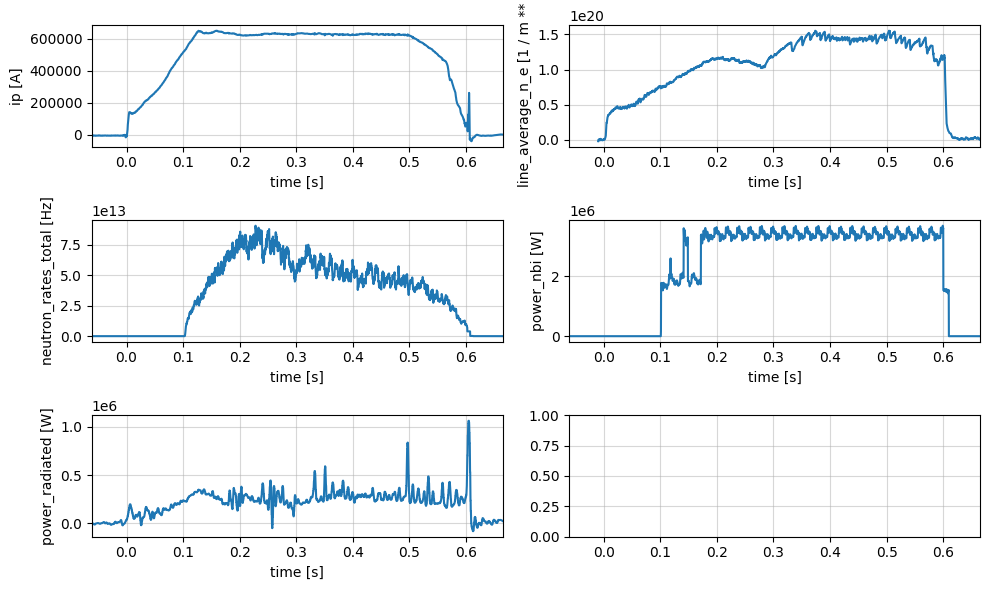

In [4]:
profiles = xr.open_zarr(store, group='summary')

plot_1d_profiles(profiles)
profiles

### Pulse Schedule

<xarray.Dataset>
Dimensions:   (time: 2906)
Coordinates:
  * time      (time) float64 -0.0612 -0.06095 -0.0607 ... 0.6645 0.6648 0.665
Data variables:
    i_plasma  (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
    n_e_line  (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
Attributes:
    description:  
    imas:         pulse_schedule
    label:        /xdc/ip/t/ipref
    name:         pulse_schedule
    uda_name:     /xdc/ip/t/ipref
    units:        A

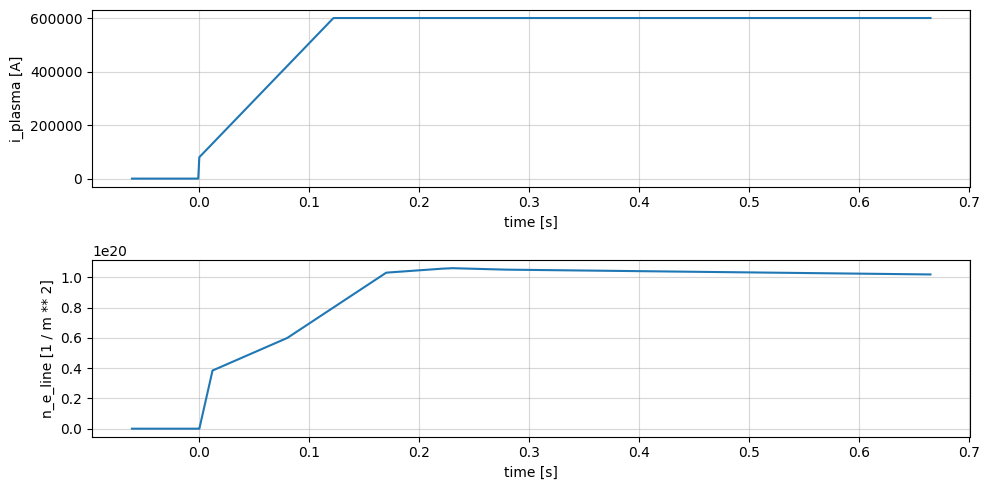

In [5]:
profiles = xr.open_zarr(store, group='pulse_schedule')

fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes = axes.flatten()
profiles['i_plasma'].plot(x='time', ax=axes[0])
profiles['n_e_line'].plot(x='time', ax=axes[1])
# profiles['vertical_control'].plot(x='time', ax=axes[2])

# for i in range(len(profiles.gas_channel)):
#     profiles['gas'].isel(gas_channel=i).plot(x='time', ax=axes[3])

for ax in axes:
    ax.grid('on', alpha=0.5)
plt.tight_layout()

profiles

### Magnetics

Magnetic diagnostics for equilibrium identification and plasma shape control.

<xarray.Dataset>
Dimensions:                           (b_field_pol_probe_cc_channel: 5,
                                       time_mirnov: 363201,
                                       b_field_pol_probe_ccbv_channel: 40,
                                       time: 3633,
                                       b_field_pol_probe_obr_channel: 18,
                                       b_field_pol_probe_obv_channel: 18,
                                       b_field_pol_probe_omv_channel: 3,
                                       b_field_tor_probe_cc_channel: 3,
                                       b_field_tor_probe_omaha_channel: 4,
                                       time_omaha: 7264001,
                                       b_field_tor_probe_saddle_channel: 24,
                                       time_saddle: 36321, flux_loop_channel: 15)
Coordinates: (12/13)
  * b_field_pol_probe_cc_channel      (b_field_pol_probe_cc_channel) <U13 'xm...
  * b_field_pol_probe_ccbv_channel    (b_field_pol_probe_ccbv_channel) <U10 '...
  * b_field_pol_probe_obr_channel     (b_field_pol_probe_obr_channel) <U9 'AM...
  * b_field_pol_probe_obv_channel     (b_field_pol_probe_obv_channel) <U9 'AM...
  * b_field_pol_probe_omv_channel     (b_field_pol_probe_omv_channel) <U11 'x...
  * b_field_tor_probe_cc_channel      (b_field_tor_probe_cc_channel) <U13 'xm...
    ...                                ...
  * b_field_tor_probe_saddle_channel  (b_field_tor_probe_saddle_channel) <U15 ...
  * flux_loop_channel                 (flux_loop_channel) <U12 'AMB_FL/CC03' ...
  * time                              (time) float64 -0.0612 -0.061 ... 0.6652
  * time_mirnov                       (time_mirnov) float64 -0.0612 ... 0.6652
  * time_omaha                        (time_omaha) float64 -0.0612 ... 0.6652
  * time_saddle                       (time_saddle) float64 -0.0612 ... 0.6652
Data variables:
    b_field_pol_probe_cc_field        (b_field_pol_probe_cc_channel, time_mirnov) float64 dask.array<chunksize=(1, 90801), meta=np.ndarray>
    b_field_pol_probe_ccbv_field      (b_field_pol_probe_ccbv_channel, time) float64 dask.array<chunksize=(20, 1817), meta=np.ndarray>
    b_field_pol_probe_obr_field       (b_field_pol_probe_obr_channel, time) float64 dask.array<chunksize=(9, 3633), meta=np.ndarray>
    b_field_pol_probe_obv_field       (b_field_pol_probe_obv_channel, time) float64 dask.array<chunksize=(9, 3633), meta=np.ndarray>
    b_field_pol_probe_omv_voltage     (b_field_pol_probe_omv_channel, time_mirnov) float64 dask.array<chunksize=(1, 90801), meta=np.ndarray>
    b_field_tor_probe_cc_field        (b_field_tor_probe_cc_channel, time_mirnov) float64 dask.array<chunksize=(1, 90801), meta=np.ndarray>
    b_field_tor_probe_omaha_voltage   (b_field_tor_probe_omaha_channel, time_omaha) float64 dask.array<chunksize=(1, 227001), meta=np.ndarray>
    b_field_tor_probe_saddle_field    (b_field_tor_probe_saddle_channel, time_saddle) float64 dask.array<chunksize=(6, 9081), meta=np.ndarray>
    b_field_tor_probe_saddle_voltage  (b_field_tor_probe_saddle_channel, time_saddle) float64 dask.array<chunksize=(6, 9081), meta=np.ndarray>
    flux_loop_flux                    (flux_loop_channel, time) float64 dask.array<chunksize=(8, 3633), meta=np.ndarray>
    ip                                (time) float64 dask.array<chunksize=(3633,), meta=np.ndarray>
Attributes:
    description:  
    imas:         magnetics
    label:        Plasma Current
    name:         magnetics
    uda_name:     AMC_PLASMA CURRENT
    units:        A

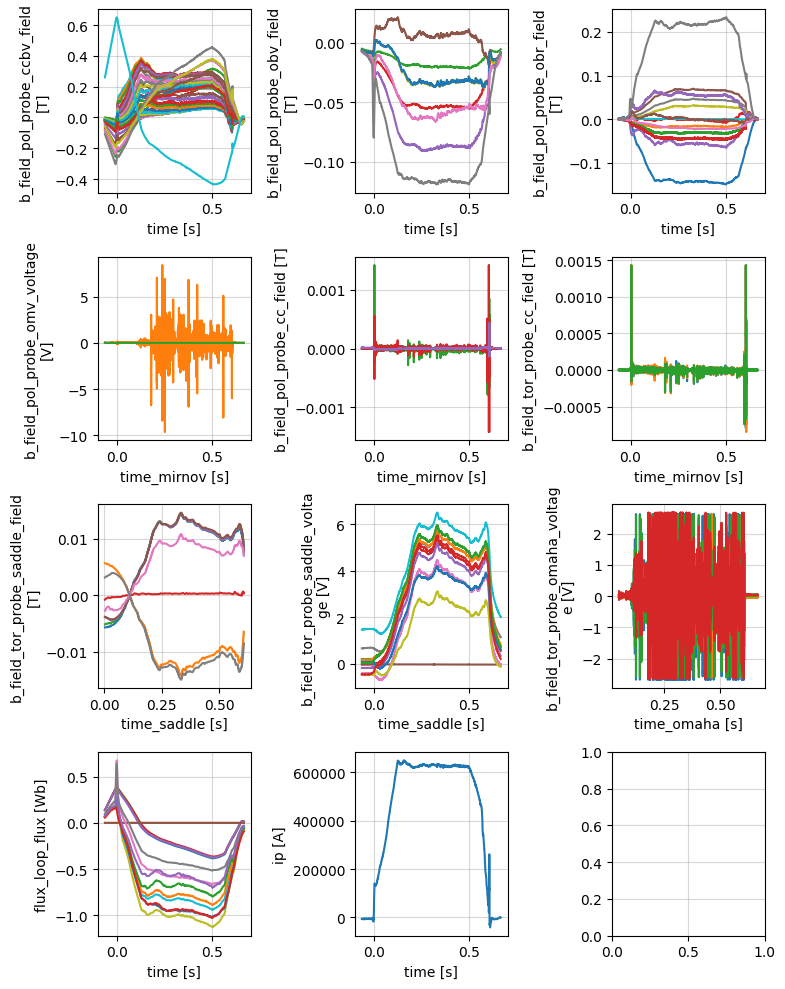

In [6]:
profiles = xr.open_zarr(store, group='magnetics')

fig, axes = plt.subplots(4, 3, figsize=(8, 10))
axes = axes.flatten()

profiles['b_field_pol_probe_ccbv_field'].plot.line(x='time', ax=axes[0], add_legend=False)
profiles['b_field_pol_probe_obv_field'].plot.line(x='time', ax=axes[1], add_legend=False)
profiles['b_field_pol_probe_obr_field'].plot.line(x='time', ax=axes[2], add_legend=False)


profiles['b_field_pol_probe_omv_voltage'].plot.line(x='time_mirnov', ax=axes[3], add_legend=False)
profiles['b_field_pol_probe_cc_field'].plot.line(x='time_mirnov', ax=axes[4], add_legend=False)
profiles['b_field_tor_probe_cc_field'].plot.line(x='time_mirnov', ax=axes[5], add_legend=False)

profiles['b_field_tor_probe_saddle_field'].plot.line(x='time_saddle', ax=axes[6], add_legend=False)
profiles['b_field_tor_probe_saddle_voltage'].plot.line(x='time_saddle', ax=axes[7], add_legend=False)
profiles['b_field_tor_probe_omaha_voltage'].plot.line(x='time_omaha', ax=axes[8], add_legend=False)

profiles['flux_loop_flux'].plot.line(x='time', ax=axes[9], add_legend=False)
profiles['ip'].plot.line(x='time', ax=axes[10], add_legend=False)

for ax in axes:
    ax.grid('on', alpha=0.5)
plt.tight_layout()

profiles

Looking at the spectrogram of one of the mirnov coils can show us information about the MHD modes. Here we see several mode instabilities occuring before the plasma is lost.

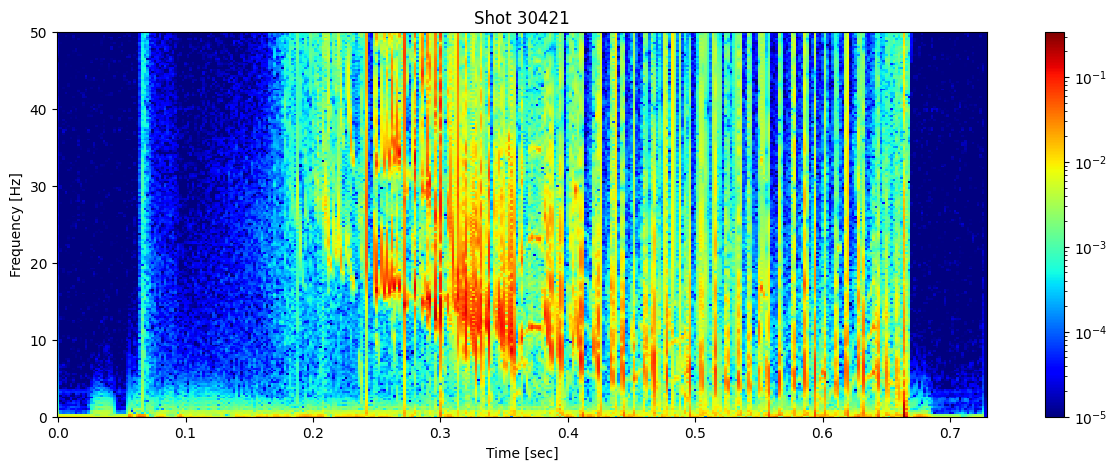

In [7]:
ds = profiles['b_field_pol_probe_omv_voltage'].isel(b_field_pol_probe_omv_channel=1)
# Parameters to limit the number of frequencies
nperseg = 2000  # Number of points per segment
nfft = 2000  # Number of FFT points

# Compute the Short-Time Fourier Transform (STFT)
sample_rate = 1/(ds.time_mirnov[1] - ds.time_mirnov[0])
f, t, Zxx = stft(ds, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

fig, ax = plt.subplots(figsize=(15, 5))
cax = ax.pcolormesh(t, f/1000, np.abs(Zxx), shading='nearest', cmap='jet', norm=LogNorm(vmin=1e-5))
ax.set_ylim(0, 50)
ax.set_title(f'Shot {shot_id}')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
plt.colorbar(cax, ax=ax)

### Spectrometer Visible

Spectrometer in visible light range diagnostic

<xarray.Dataset>
Dimensions:                             (bes_channel: 32, dalpha_channel: 3,
                                         time: 36321, time_bes: 1452801)
Coordinates:
  * bes_channel                         (bes_channel) <U13 'xbt/channel01' .....
  * dalpha_channel                      (dalpha_channel) <U13 'XIM_DA/HM10/R'...
  * time                                (time) float64 -0.0612 ... 0.6652
  * time_bes                            (time_bes) float64 -0.0612 ... 0.6652
Data variables:
    density_gradient                    (time) float64 dask.array<chunksize=(18161,), meta=np.ndarray>
    filter_spectrometer_bes_voltage     (bes_channel, time_bes) float64 dask.array<chunksize=(2, 90801), meta=np.ndarray>
    filter_spectrometer_dalpha_voltage  (dalpha_channel, time) float64 dask.array<chunksize=(2, 18161), meta=np.ndarray>
Attributes:
    description:  
    imas:         None
    label:        Volt
    name:         spectrometer_visible
    uda_name:     XIM_DA/HM10/R
    units:        V

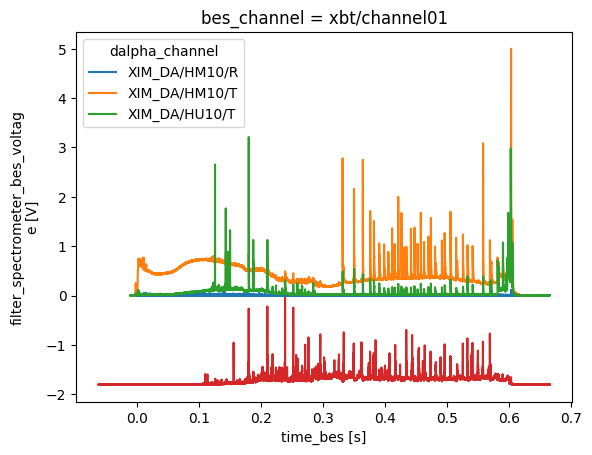

In [8]:
profiles = xr.open_zarr(store, group='spectrometer_visible')
profiles['filter_spectrometer_dalpha_voltage'].plot.line(x='time')
profiles['filter_spectrometer_bes_voltage'].isel(bes_channel=0).plot.line(x='time_bes')
profiles


### PF Active

<xarray.Dataset>
Dimensions:           (channel: 14, time: 2906)
Coordinates:
  * channel           (channel) <U21 '/xdc/pf/f/p1' ... 'AMC_P5U FEED CURRENT'
  * time              (time) float64 -0.0612 -0.06095 -0.0607 ... 0.6648 0.665
Data variables:
    coil_current      (channel, time) float64 dask.array<chunksize=(7, 2906), meta=np.ndarray>
    coil_voltage      (channel, time) float64 dask.array<chunksize=(7, 2906), meta=np.ndarray>
    solenoid_current  (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
Attributes:
    description:  
    imas:         pf_active
    label:        Sol Current
    name:         pf_active
    uda_name:     AMC_SOL CURRENT
    units:        A

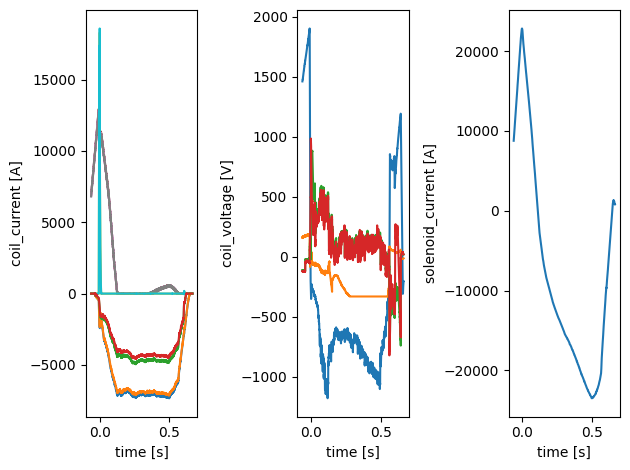

In [9]:
profiles = xr.open_zarr(store, group='pf_active')
fig, axes = plt.subplots(1, 3)
axes = axes.flatten()

profiles['coil_current'].plot.line(x='time', ax=axes[0], add_legend=False)
profiles['coil_voltage'].plot.line(x='time', ax=axes[1], add_legend=False)
profiles['solenoid_current'].plot.line(x='time', ax=axes[2], add_legend=False)

plt.tight_layout()
profiles

### Soft X-rays

<xarray.Dataset>
Dimensions:                       (horizontal_cam_lower_channel: 18,
                                   time: 363201,
                                   horizontal_cam_upper_channel: 18,
                                   tangential_cam_channel: 18)
Coordinates:
  * horizontal_cam_lower_channel  (horizontal_cam_lower_channel) <U14 '/xsx/H...
  * horizontal_cam_upper_channel  (horizontal_cam_upper_channel) <U14 '/xsx/H...
  * tangential_cam_channel        (tangential_cam_channel) <U12 '/xsx/TCAM/1'...
  * time                          (time) float64 -0.0612 -0.0612 ... 0.6652
Data variables:
    horizontal_cam_lower          (horizontal_cam_lower_channel, time) float64 dask.array<chunksize=(3, 45401), meta=np.ndarray>
    horizontal_cam_upper          (horizontal_cam_upper_channel, time) float64 dask.array<chunksize=(3, 45401), meta=np.ndarray>
    tangential_cam                (tangential_cam_channel, time) float64 dask.array<chunksize=(3, 45401), meta=np.ndarray>
Attributes:
    description:  
    imas:         None
    label:        Volt
    name:         soft_x_rays
    uda_name:     /xsx/TCAM/1
    units:        V

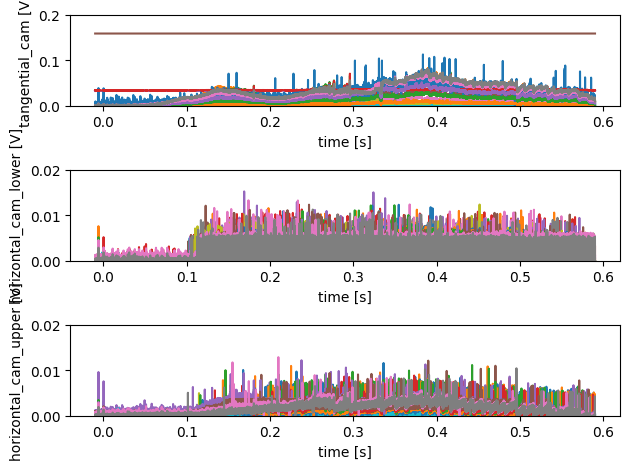

In [10]:
profiles = xr.open_zarr(store, group='soft_x_rays')
fig, axes = plt.subplots(3, 1)


profiles['horizontal_cam_lower'].plot.line(x='time', ax=axes[1], add_legend=False)
axes[1].set_ylim(0, 0.02)

profiles['horizontal_cam_upper'].plot.line(x='time', ax=axes[2], add_legend=False)
axes[2].set_ylim(0, 0.02)

if "tangential_cam" in profiles:
    profiles['tangential_cam'].plot.line(x='time', ax=axes[0], add_legend=False)
    axes[0].set_ylim(0, 0.2)

plt.tight_layout()
profiles

### Thomson Profiles

Thomson scattering measurements in a tokamak provide information about the plasma's electron temperature and density profiles. The diagnostic analyses the scattering of laser light off free electrons in the plasma from a number of radial channels.

Below we plot the following profiles measured by the Thomson diagnostic

- $T_e$ - Electron temperature
- $N_e$ - Electron density
- $P_e$ - Electron pressure

<xarray.Dataset>
Dimensions:       (major_radius: 120, time: 146)
Coordinates:
  * major_radius  (major_radius) float64 0.3 0.31 0.32 0.33 ... 1.47 1.48 1.49
  * time          (time) float64 -0.0612 -0.0562 -0.0512 ... 0.6588 0.6638
Data variables:
    n_e           (time, major_radius) float64 dask.array<chunksize=(146, 120), meta=np.ndarray>
    n_e_core      (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    p_e           (time, major_radius) float64 dask.array<chunksize=(146, 120), meta=np.ndarray>
    t_e           (time, major_radius) float64 dask.array<chunksize=(146, 120), meta=np.ndarray>
    t_e_core      (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
Attributes:
    description:  
    imas:         thomson_scattering
    label:        core temperature
    name:         thomson_scattering
    uda_name:     AYC_TE_CORE
    units:        eV

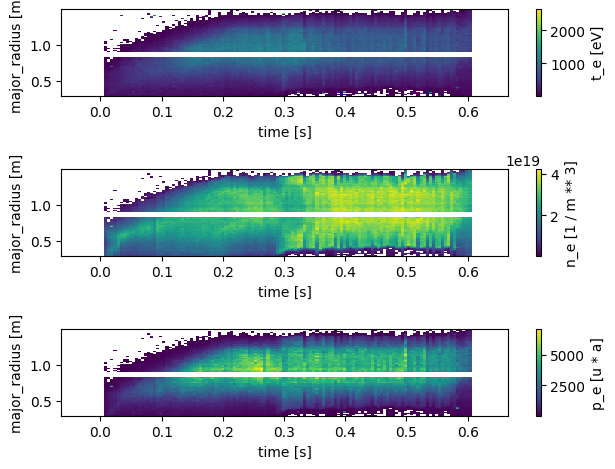

In [11]:
profiles = xr.open_zarr(store, group='thomson_scattering')
profiles

fig, axes = plt.subplots(3, 1)
axes = axes.flatten()
profiles.t_e.plot(x='time', y='major_radius', ax=axes[0])
profiles.n_e.plot(x='time', y='major_radius', ax=axes[1])
profiles.p_e.plot(x='time', y='major_radius', ax=axes[2])
plt.tight_layout()

profiles

<xarray.Dataset>
Dimensions:       (major_radius: 120, time: 146)
Coordinates:
  * major_radius  (major_radius) float64 0.3 0.31 0.32 0.33 ... 1.47 1.48 1.49
  * time          (time) float64 -0.0612 -0.0562 -0.0512 ... 0.6588 0.6638
Data variables:
    n_e           (time, major_radius) float64 dask.array<chunksize=(146, 120), meta=np.ndarray>
    n_e_core      (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    p_e           (time, major_radius) float64 dask.array<chunksize=(146, 120), meta=np.ndarray>
    t_e           (time, major_radius) float64 dask.array<chunksize=(146, 120), meta=np.ndarray>
    t_e_core      (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
Attributes:
    description:  
    imas:         thomson_scattering
    label:        core temperature
    name:         thomson_scattering
    uda_name:     AYC_TE_CORE
    units:        eV

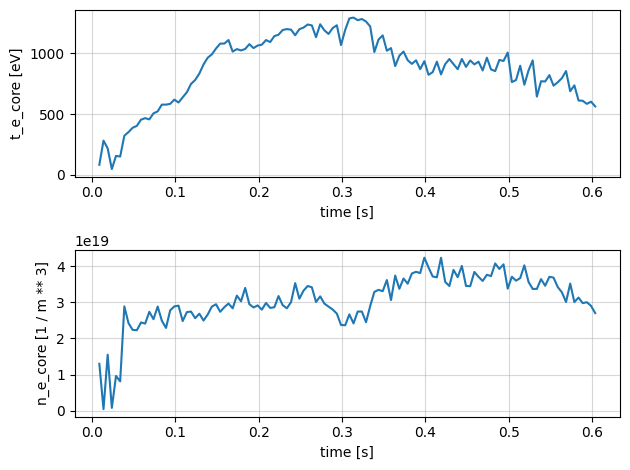

In [12]:
fig, axes = plt.subplots(2, 1)
profiles['t_e_core'].plot(x='time', ax=axes[0])
profiles['n_e_core'].plot(x='time', ax=axes[1])
for ax in axes:
    ax.grid('on', alpha=0.5)
plt.tight_layout()
profiles

### CXRS Profiles

Charge Exchange Recombination Spectroscopy (CXRS) measurements provide information about ion temperature and plasma rotation. This diagnostic analyses the light emitted from charge exchange reactions between injected neutral beams and plasma ions.

Below we plot the following profiles measured by the CXRS diagnostic

 - $T_i$ - Ion temperature
 - $V_i$ - Ion velocity

<xarray.Dataset>
Dimensions:       (major_radius: 160, time: 73)
Coordinates:
  * major_radius  (major_radius) float64 0.0 0.01 0.02 0.03 ... 1.57 1.58 1.59
  * time          (time) float64 -0.0612 -0.0512 -0.0412 ... 0.6488 0.6588
Data variables:
    t_i           (time, major_radius) float64 dask.array<chunksize=(73, 160), meta=np.ndarray>
    v_i           (time, major_radius) float64 dask.array<chunksize=(73, 160), meta=np.ndarray>
Attributes:
    description:  
    imas:         charge_exchange
    label:        Carbon temperature
    name:         charge_exchange
    uda_name:     ACT_SS_TEMPERATURE
    units:        eV

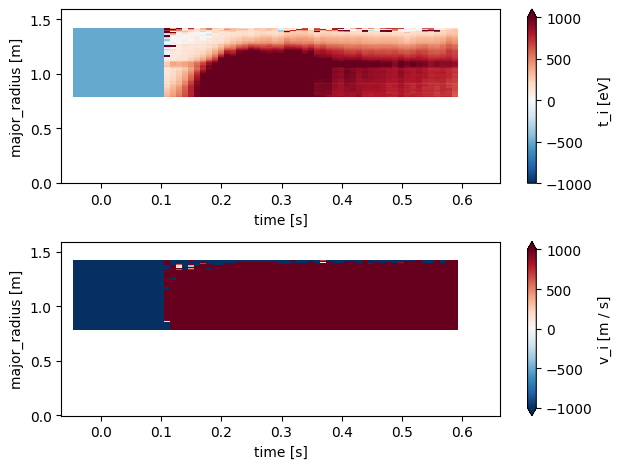

In [13]:
profiles = xr.open_zarr(store, group='charge_exchange')

fig, axes = plt.subplots(2, 1)
profiles['t_i'].plot(x='time', y='major_radius', ax=axes[0], vmax=1000)
profiles['v_i'].plot(x='time', y='major_radius', ax=axes[1], vmax=1000)
plt.tight_layout()
profiles

### Equilibrium

<xarray.Dataset>
Dimensions:              (time: 146, z: 65, major_radius: 65,
                          n_boundary_coords: 139, n_x_points: 4, profile_r: 65)
Coordinates:
  * major_radius         (major_radius) float64 0.06 0.09 0.12 ... 1.95 1.98
  * n_boundary_coords    (n_boundary_coords) float32 0.0 1.0 2.0 ... 137.0 138.0
  * n_x_points           (n_x_points) <U16 'EFM_XPOINT1_R(C)' ... 'EFM_XPOINT...
  * profile_r            (profile_r) float32 0.0 0.01562 0.03125 ... 0.9844 1.0
  * time                 (time) float64 -0.0612 -0.0562 ... 0.6588 0.6638
  * z                    (z) float32 -2.0 -1.938 -1.875 ... 1.875 1.938 2.0
Data variables: (12/35)
    beta_normal          (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    beta_pol             (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    beta_tor             (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    bphi_rmag            (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    bvac_rmag            (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    da_rating            (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    ...                   ...
    triangularity_upper  (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    vloop_dynamic        (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    vloop_static         (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    whmd                 (time) float64 dask.array<chunksize=(146,), meta=np.ndarray>
    x_point_r            (n_x_points, time) float64 dask.array<chunksize=(4, 146), meta=np.ndarray>
    x_point_z            (n_x_points, time) float64 dask.array<chunksize=(4, 146), meta=np.ndarray>
Attributes:
    description:  
    imas:         equilibrium
    label:        q(r) at z=0.
    name:         equilibrium
    uda_name:     EFM_Q(R)
    units:

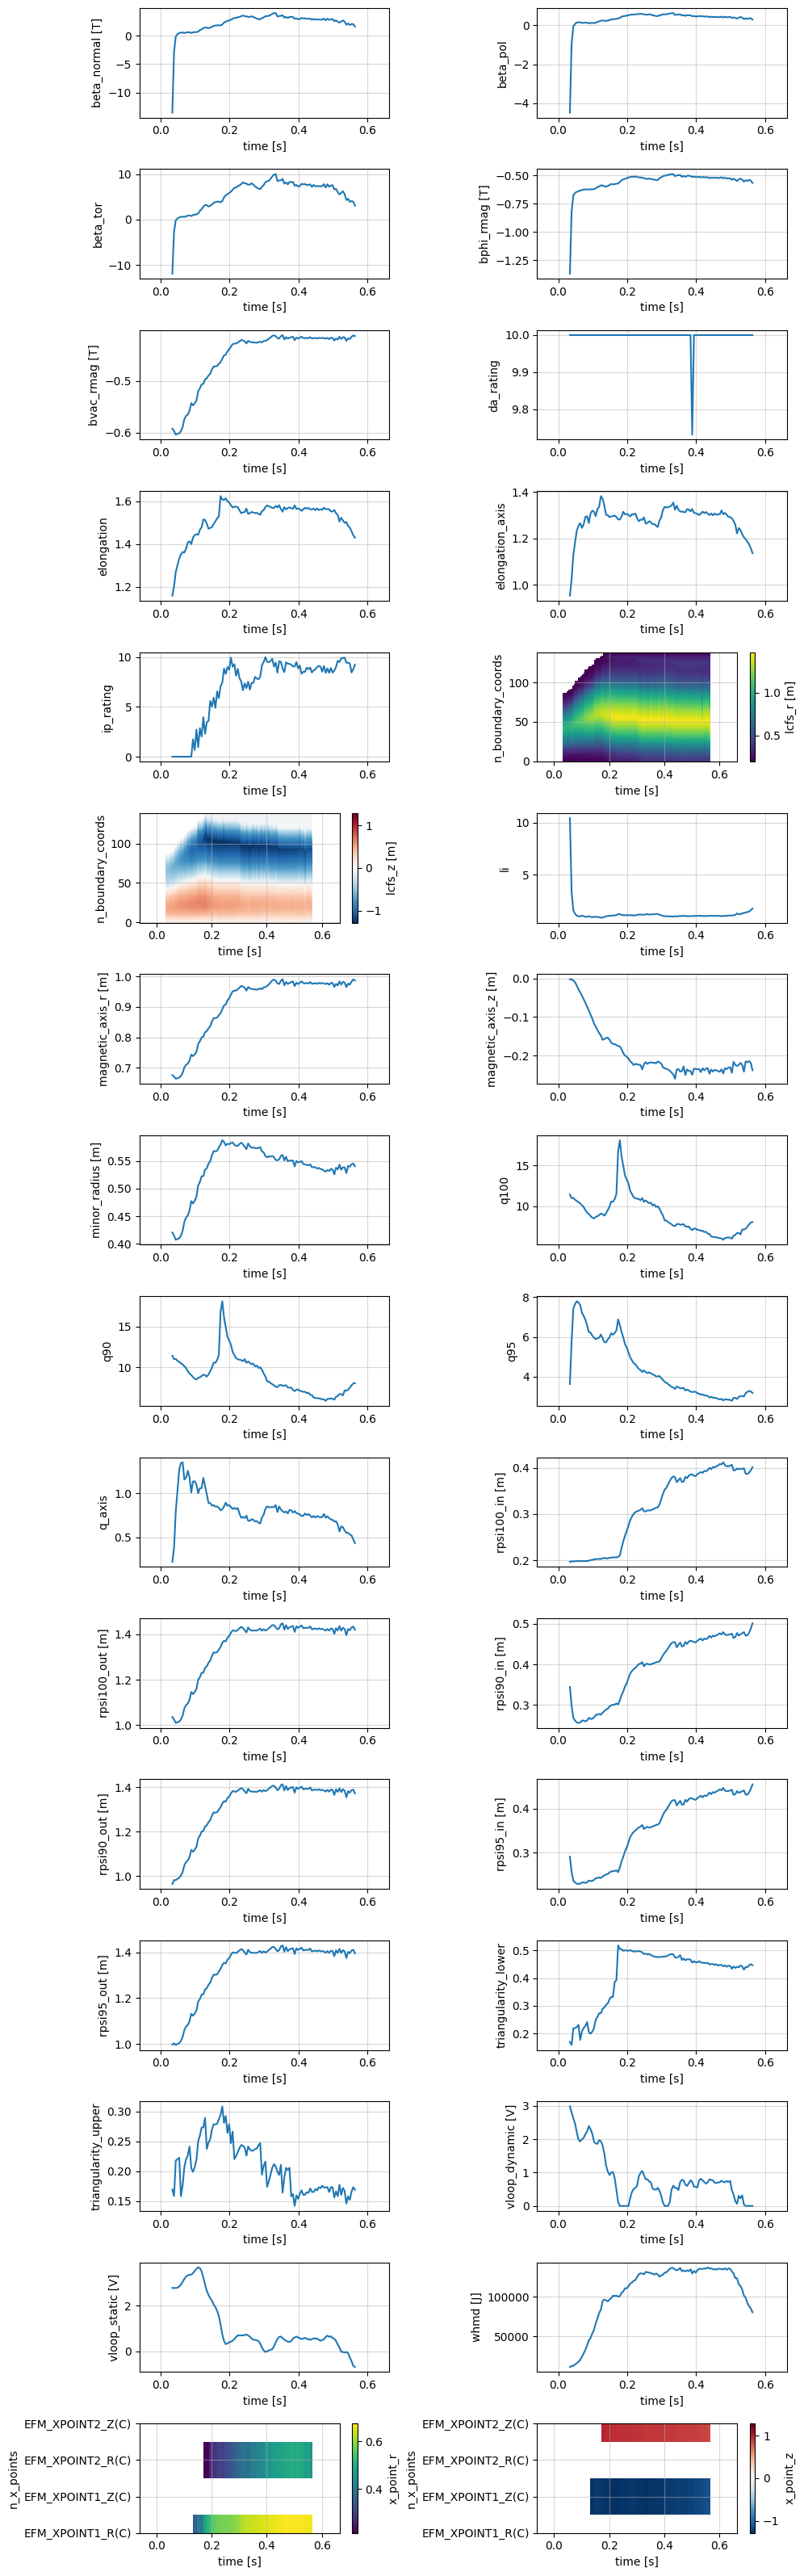

In [14]:
profiles = xr.open_zarr(store, group='equilibrium')

profile_1d = profiles.drop_vars(['j_tor', 'psi', 'q'])
plot_1d_profiles(profile_1d)

profiles

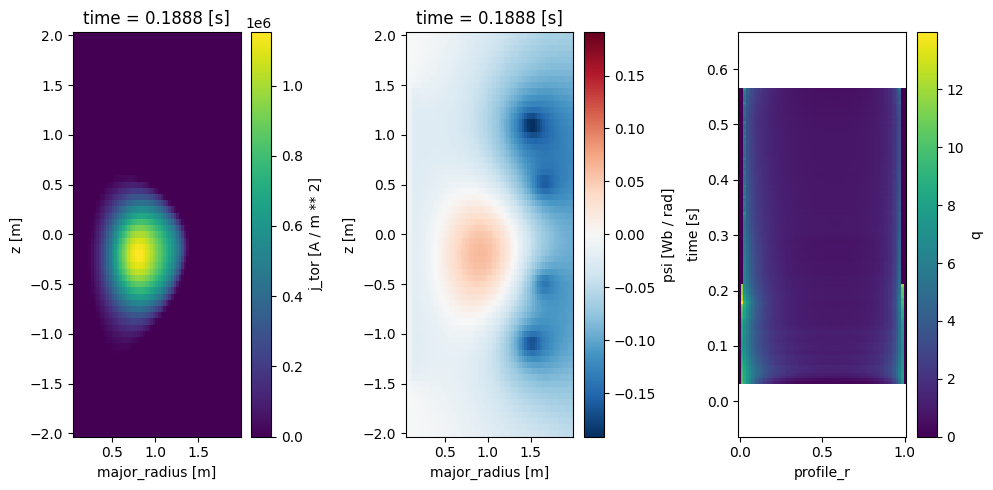

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

profiles['j_tor'].isel(time=50).plot(ax=axes[0], x='major_radius')
profiles['psi'].isel(time=50).plot(ax=axes[1], x='major_radius')
profiles['q'].plot(ax=axes[2])
plt.tight_layout()

### Gas Injection

<xarray.Dataset>
Dimensions:         (time: 2906)
Coordinates:
  * time            (time) float64 -0.0612 -0.06095 -0.0607 ... 0.6648 0.665
Data variables:
    inboard_total   (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
    outboard_total  (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
    pressure        (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
    total_injected  (time) float64 dask.array<chunksize=(2906,), meta=np.ndarray>
Attributes:
    description:  
    imas:         gas_injection
    label:        Integrated total gas
    name:         gas_injection
    uda_name:     AGA_INTEG_GAS
    units:        count

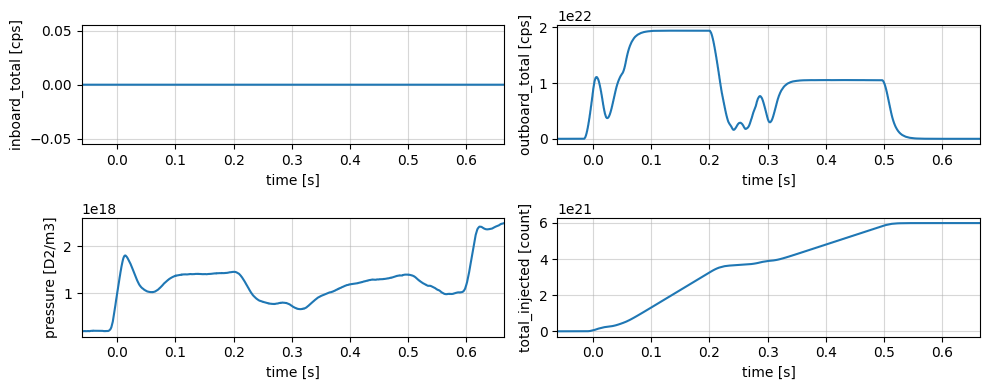

In [16]:
profiles = xr.open_zarr(store, group='gas_injection')

plot_1d_profiles(profiles)
plt.tight_layout()
profiles